<a href="https://www.kaggle.com/code/vanpatangan/world-population-eda-predictions?scriptVersionId=196186037" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Import libraries and read in data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/world-population-statistics-2023/world_population_data.csv')

# overview

In [2]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

print("Data Summary")
display(check(df))
display(df.head())

Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,rank,int64,234,234,0,0
1,cca3,object,234,234,0,0
2,country,object,234,234,0,0
3,continent,object,234,6,0,0
4,2023 population,int64,234,234,0,0
5,2022 population,int64,234,234,0,0
6,2020 population,int64,234,234,0,0
7,2015 population,int64,234,234,0,0
8,2010 population,int64,234,234,0,0
9,2000 population,int64,234,234,0,0


,rank,cca3,country,continent,2023 population,2022 population,2020 population,2015 population,2010 population,2000 population,1990 population,1980 population,1970 population,area (km²),density (km²),growth rate,world percentage
0,1,IND,India,Asia,1428627663,1417173173,1396387127,1322866505,1240613620,1059633675,870452165,696828385,557501301,3287590.0,481,0.81%,17.85%
1,2,CHN,China,Asia,1425671352,1425887337,1424929781,1393715448,1348191368,1264099069,1153704252,982372466,822534450,9706961.0,151,-0.02%,17.81%
2,3,USA,United States,North America,339996563,338289857,335942003,324607776,311182845,282398554,248083732,223140018,200328340,9372610.0,37,0.50%,4.25%
3,4,IDN,Indonesia,Asia,277534122,275501339,271857970,259091970,244016173,214072421,182159874,148177096,115228394,1904569.0,148,0.74%,3.47%
4,5,PAK,Pakistan,Asia,240485658,235824862,227196741,210969298,194454498,154369924,115414069,80624057,59290872,881912.0,312,1.98%,3.00%


# visualization

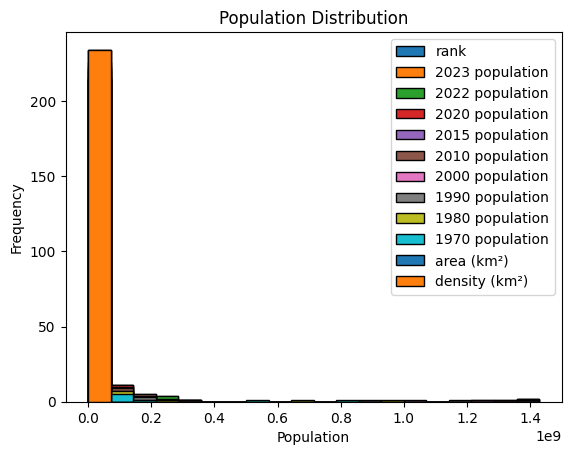

In [3]:
# Visualize data distribution
df.plot(kind='hist', bins=20, edgecolor='black')
plt.title('Population Distribution')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

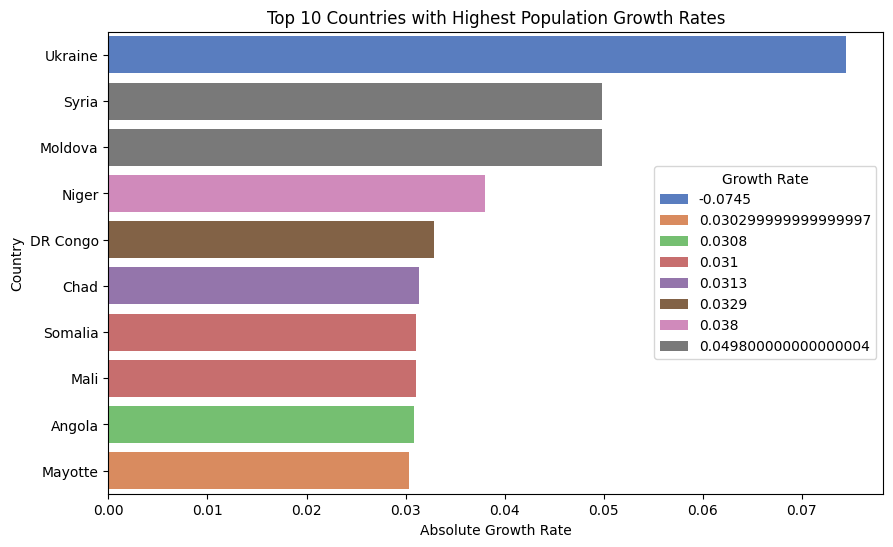

In [4]:
# Sort the DataFrame by absolute growth rate in descending order
df_sorted = df.copy()
df_sorted['growth rate'] = df_sorted['growth rate'].str.rstrip('%').astype('float') / 100.0  # Convert growth rate to a numeric value
df_sorted['abs_growth_rate'] = df_sorted['growth rate'].abs()  # Absolute growth rate
df_sorted = df_sorted.sort_values(by='abs_growth_rate', ascending=False).head(10)  # Select top 10 countries

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='abs_growth_rate', y='country', hue='growth rate', data=df_sorted, palette='muted', dodge=False)
plt.title('Top 10 Countries with Highest Population Growth Rates')
plt.xlabel('Absolute Growth Rate')
plt.ylabel('Country')
plt.legend(title='Growth Rate')
plt.show()

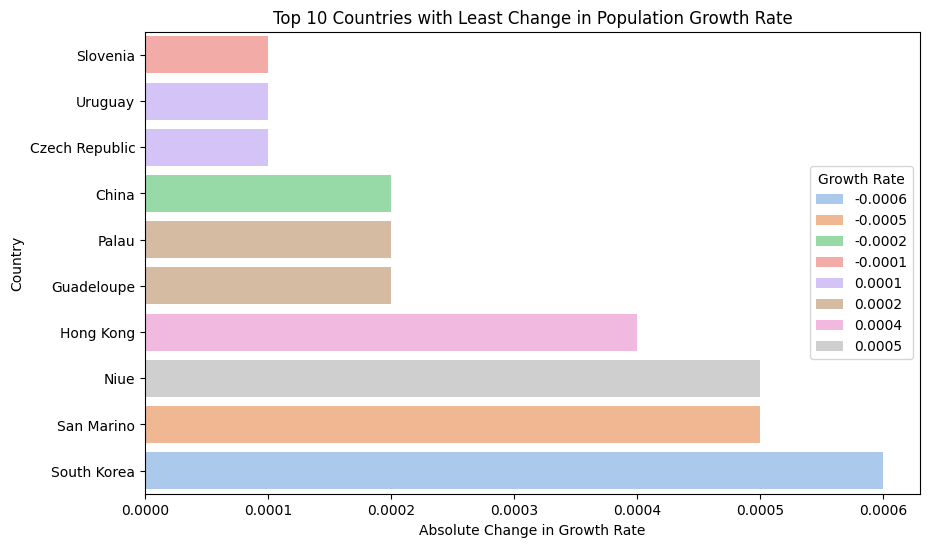

In [5]:
# Sort the DataFrame by absolute growth rate in ascending order
df_sorted_low_change = df.copy()
df_sorted_low_change['growth rate'] = df_sorted_low_change['growth rate'].str.rstrip('%').astype('float') / 100.0  # Convert growth rate to a numeric value
df_sorted_low_change['abs_growth_rate'] = df_sorted_low_change['growth rate'].abs()  # Absolute growth rate
df_sorted_low_change = df_sorted_low_change.sort_values(by='abs_growth_rate', ascending=True).head(10)  # Select top 10 countries

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='abs_growth_rate', y='country', hue='growth rate', data=df_sorted_low_change, palette='pastel', dodge=False)
plt.title('Top 10 Countries with Least Change in Population Growth Rate')
plt.xlabel('Absolute Change in Growth Rate')
plt.ylabel('Country')
plt.legend(title='Growth Rate')
plt.show()


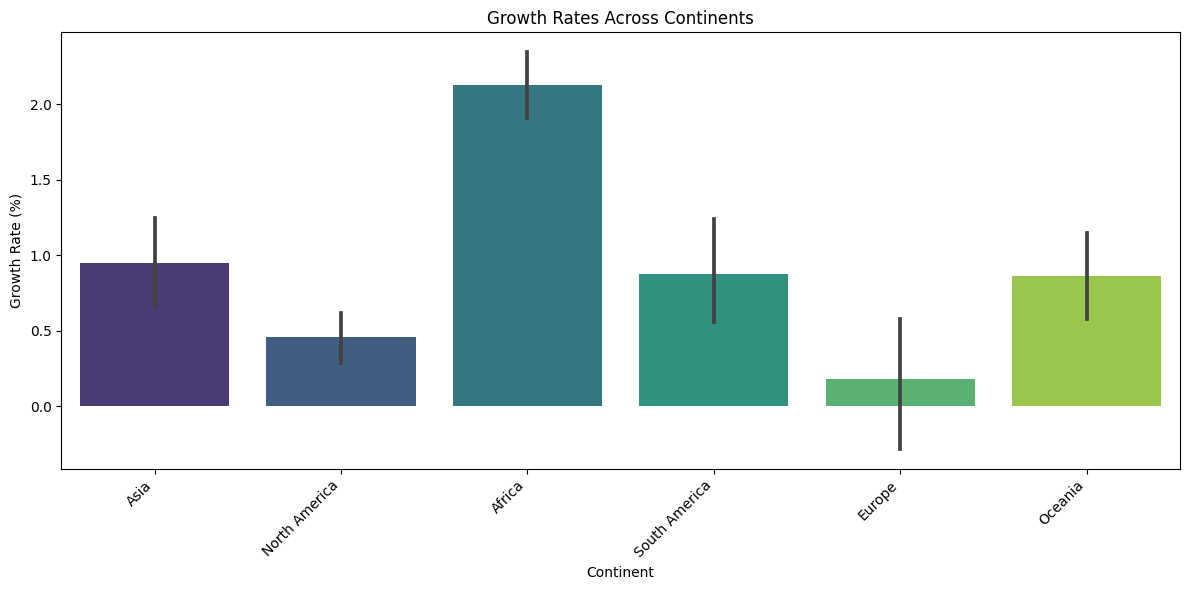

In [6]:
df['growth rate'] = df['growth rate'].astype(str)

# Replace non-numeric values with NaN and convert to numeric
df['growth rate'] = pd.to_numeric(df['growth rate'].str.replace('%', ''), errors='coerce')

# Create a bar plot to compare growth rates across continents
plt.figure(figsize=(12, 6))
sns.barplot(x='continent', y='growth rate', data=df, palette='viridis')
plt.title('Growth Rates Across Continents')
plt.xlabel('Continent')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

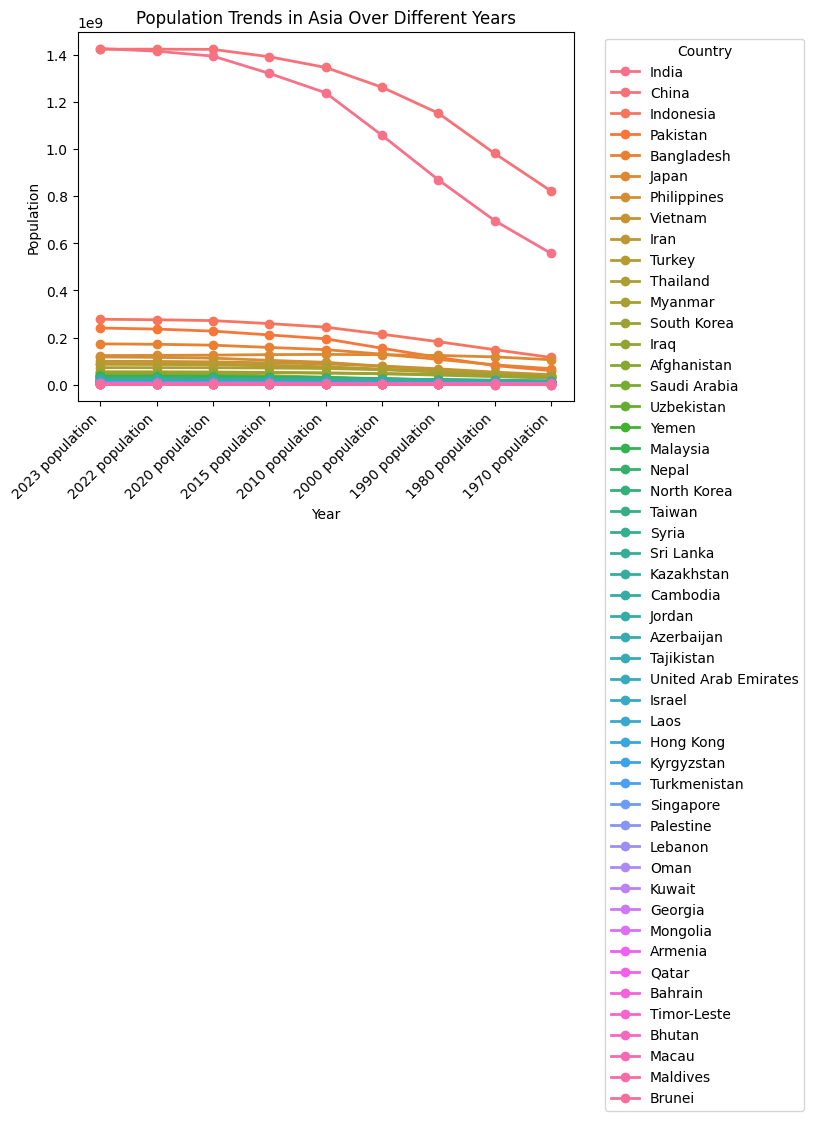

<Figure size 1600x800 with 0 Axes>

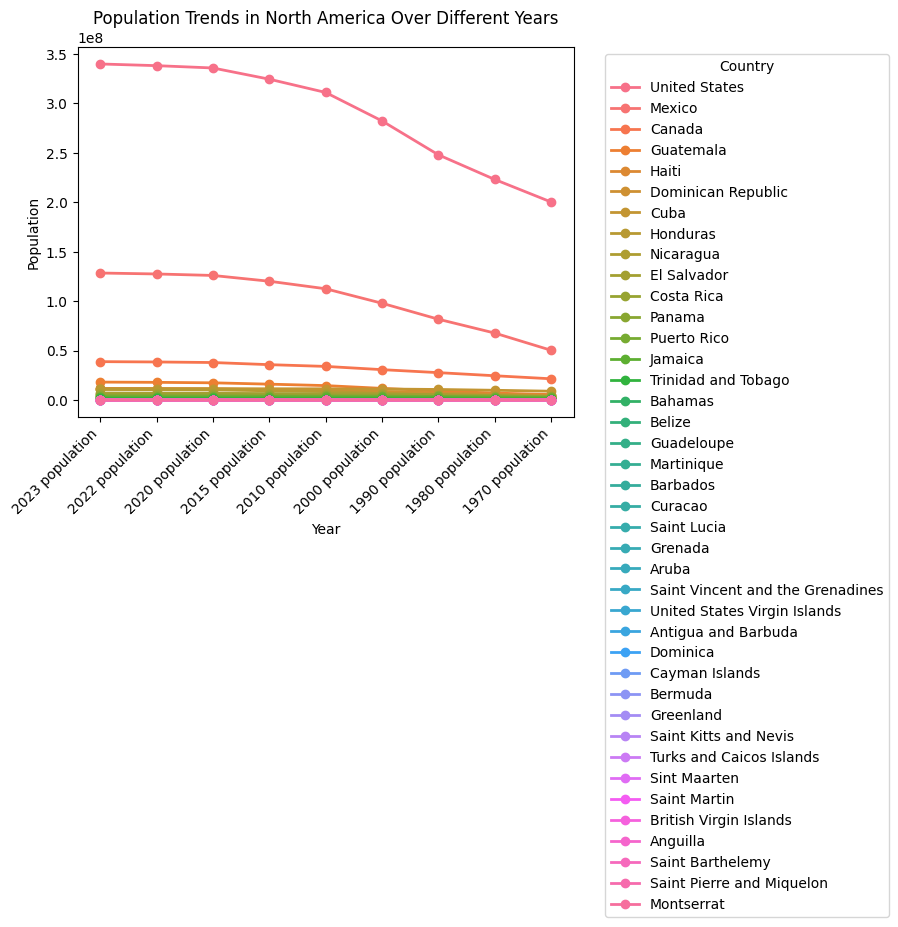

<Figure size 1600x800 with 0 Axes>

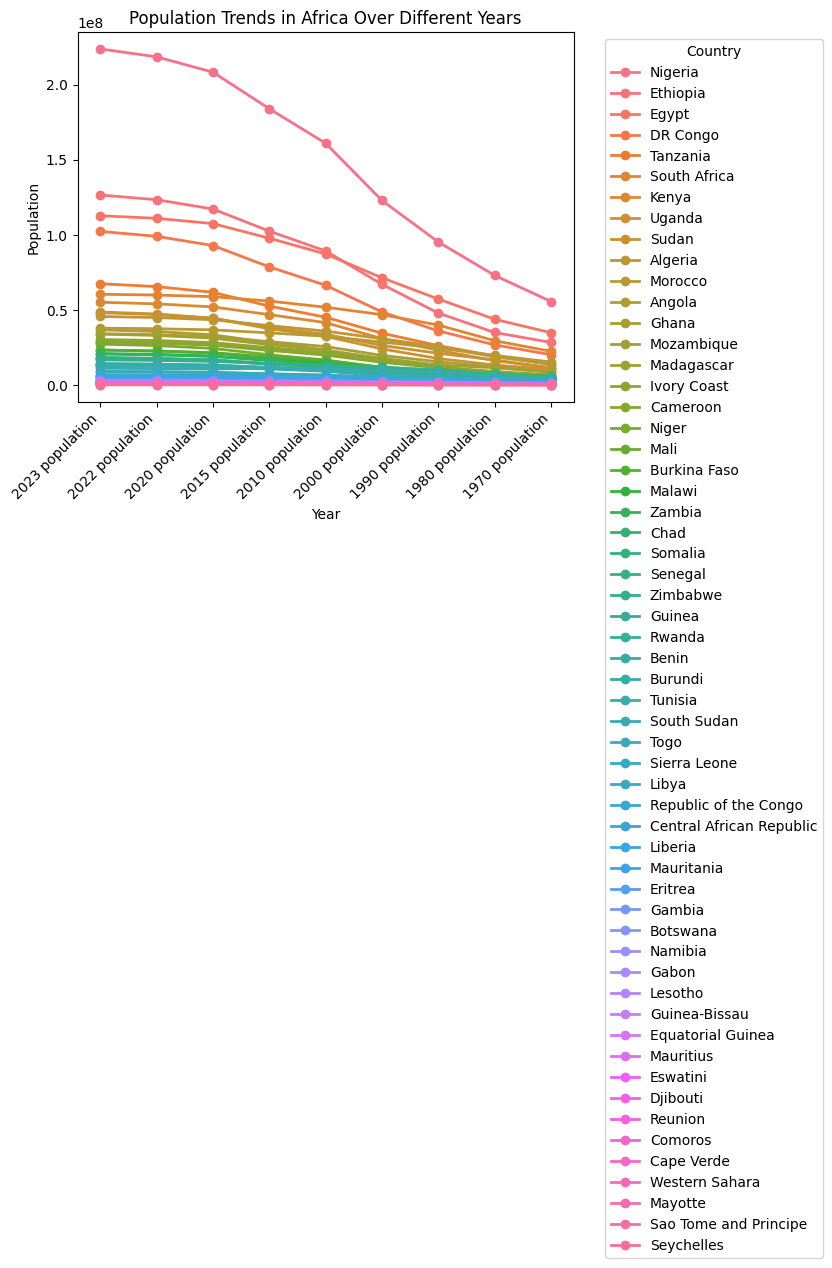

<Figure size 1600x800 with 0 Axes>

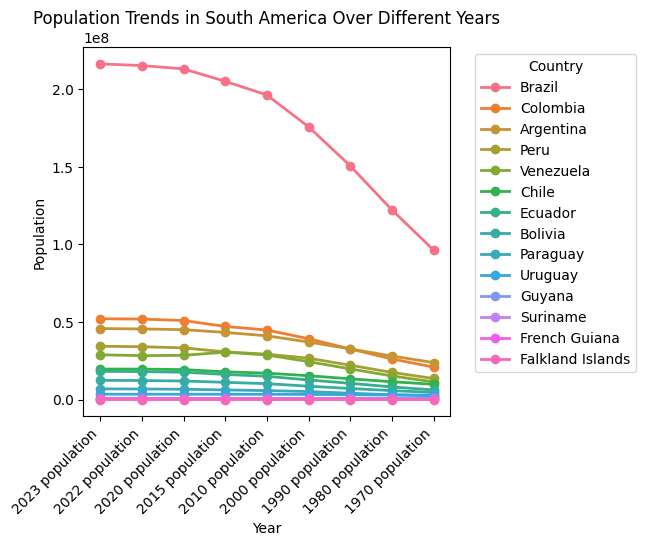

<Figure size 1600x800 with 0 Axes>

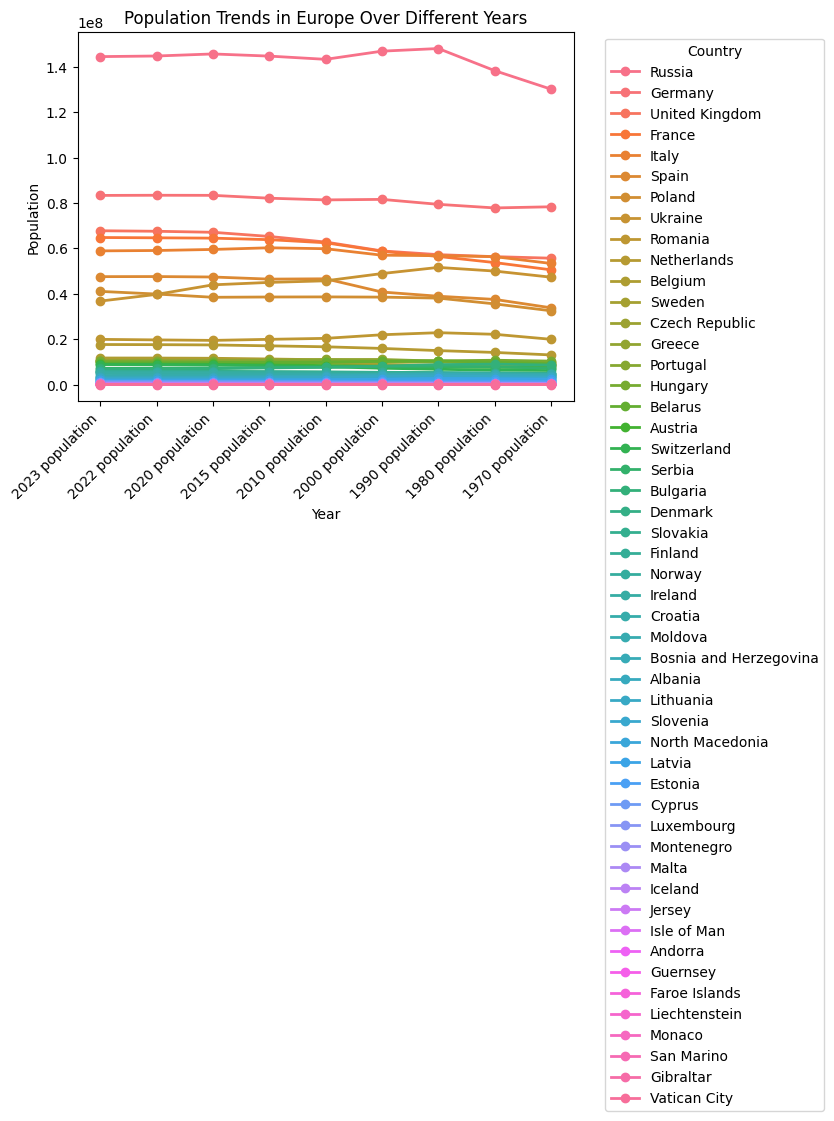

<Figure size 1600x800 with 0 Axes>

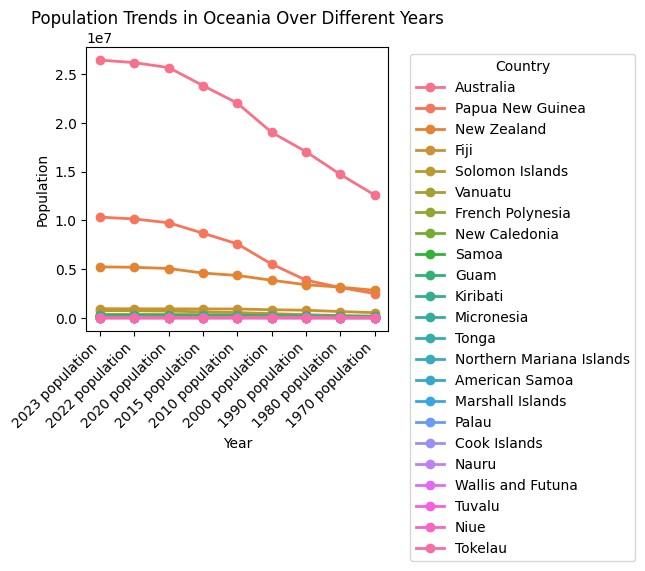

In [7]:
# Select relevant columns for population trends
population_columns = ['country', 'continent', '2023 population', '2022 population', '2020 population', '2015 population', '2010 population', '2000 population', '1990 population', '1980 population', '1970 population']

# Extract the data for the selected columns
population_trends = df[population_columns]

# Iterate over each continent
for continent in population_trends['continent'].unique():
    # Filter the data for the current continent
    continent_data = population_trends[population_trends['continent'] == continent]
    
    # Set 'country' as the index for easier plotting
    continent_data.set_index('country', inplace=True)
    
    # Transpose the DataFrame to have years as rows and countries as columns
    continent_data = continent_data.drop(columns=['continent']).T
    
    # Plot population trends using a line plot
    plt.figure(figsize=(16, 8))
    sns.set_palette("husl", len(continent_data.columns))  # Adjust the palette for clarity
    continent_data.plot(kind='line', marker='o', linewidth=2)
    
    # Customize the plot
    plt.title(f'Population Trends in {continent} Over Different Years')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.show()


# preprocess

In [8]:
# Convert growth rate and world percentage to numeric (removing any percentage signs)
df['growth rate'] = df['growth rate'].astype(str).str.rstrip('%').replace('nan', np.nan).astype(float) / 100
df['world percentage'] = df['world percentage'].astype(str).str.rstrip('%').replace('nan', np.nan).astype(float) / 100

# Select relevant columns for modeling
population_columns = ['2023 population', '2022 population', '2020 population', '2015 population', '2010 population', 
                      '2000 population', '1990 population', '1980 population', '1970 population']

# Creating a new DataFrame for modeling
population_df = df[['country', 'continent'] + population_columns]

# Apply log transformation to population data
population_df[population_columns] = np.log1p(population_df[population_columns].astype(float))

# Feature Engineering: Calculate differences between population years as growth indicators
for i in range(1, len(population_columns)):
    population_df[f'pop_diff_{i}'] = population_df[population_columns[i-1]] - population_df[population_columns[i]]


In [9]:
# Set up the data to train on the most recent population columns
X = population_df[['2023 population', '2022 population', '2020 population', 'pop_diff_1', 'pop_diff_2', 'pop_diff_3']]
y = population_df['2023 population']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# modeling

In [10]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': sp_randint(500, 1500),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': sp_randint(3, 10),
    'num_leaves': sp_randint(20, 150),
    'min_child_samples': sp_randint(20, 100),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

# Create the LGBMRegressor model
lgb_model = LGBMRegressor(random_state=42)

# Set up RandomizedSearchCV
n_iter_search = 100  # Number of parameter settings sampled
random_search = RandomizedSearchCV(
    lgb_model, param_distributions=param_dist, 
    n_iter=n_iter_search, scoring='neg_mean_absolute_error', 
    cv=3, random_state=42, n_jobs=-1, verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Print the best parameters found
print(f"Best parameters: {random_search.best_params_}")

# Predict the population for the next 4 years (2024, 2025, 2026, 2027)
# Use the best model found from RandomizedSearchCV
future_years = [2024, 2025, 2026, 2027]
X_future = X_test.copy()  # Copy the test set as a base

# Simulate predictions for each future year using previous predictions
for year in future_years:
    future_pred = best_model.predict(X_future)
    print(f'Predicted Population for {year}: {np.mean(future_pred)}')
    
    # Shift the columns to update the features for the next year's prediction
    X_future['2023 population'] = future_pred
    X_future['2022 population'] = X_future['2023 population']


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 20, 'n_estimators': 904, 'num_leaves': 74, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.6}
Predicted Population for 2024: 14.622663727664639
Predicted Population for 2025: 14.62825280080016
Predicted Population for 2026: 14.641382031524403
Predicted Population for 2027: 14.661145100282148


# model evaluation 

MAE: 0.28862825378115314
RMSE: 0.43142950909373556


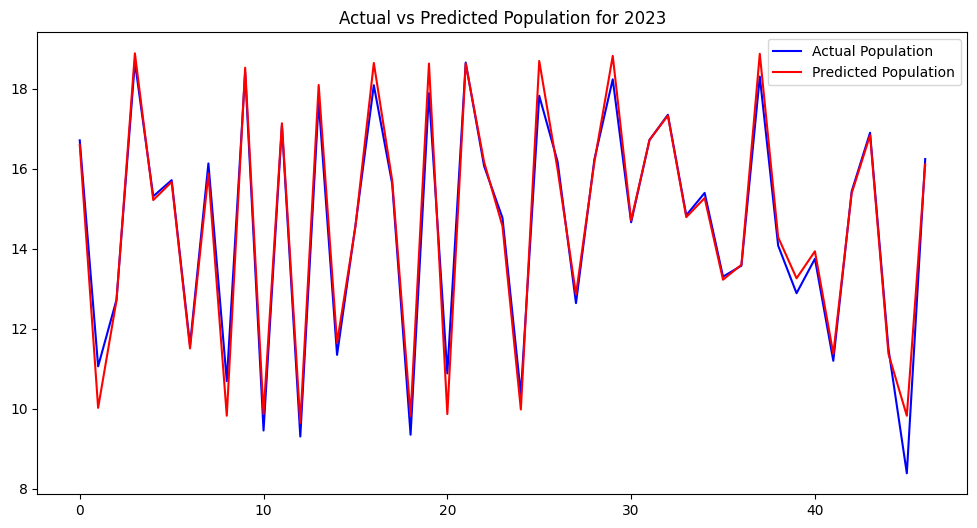

In [11]:
# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test.values, color='blue', label="Actual Population")
plt.plot(y_pred, color='red', label="Predicted Population")
plt.title("Actual vs Predicted Population for 2023")
plt.legend()
plt.show()